# MCC RF 
## Neema Zadeh 9/16/2021

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pytz
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from datetime import datetime

%matplotlib inline

from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.arima_model import AR
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


from sklearn import preprocessing
plt.rc("font", size=14)


In [3]:
#show entire dataframe

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [4]:
#get the EF output
train_data = pd.read_csv("input_data.csv")
train_data['date_utc'] = pd.to_datetime(train_data['date_utc'])

In [5]:
#add netload to the train data before joing with MCC
train_data['wind/load_sys ratio']=train_data['wind_system_level']/train_data['load_system_level']
train_data['wind/load_west ratio']=train_data['wind_lz_west']/train_data['load_lz_west']
train_data['wind/load_south ratio']=train_data['wind_lz_south_houston']/train_data['load_lz_south']
train_data['wind/load_north ratio']=train_data['wind_lz_north']/train_data['load_lz_north']

train_data['net_load_sys']=train_data['load_system_level']-train_data['wind_system_level']-train_data['solar_system_level']
train_data['net_load_west']=train_data['load_lz_west']-train_data['wind_lz_west']
train_data['net_load_south']=train_data['load_lz_south']-train_data['wind_lz_south_houston']
train_data['net_load_north']=train_data['load_lz_north']-train_data['wind_lz_north']


#create AS features
train_data['regup/load']=train_data['ercot_asp_regup']/train_data['load_system_level']
train_data['regdn/load']=train_data['ercot_asp_regdn']/train_data['load_system_level']
train_data['rrs/load']=train_data['ercot_asp_rrs']/train_data['load_system_level']
train_data['nspin/load']=train_data['ercot_asp_nspin']/train_data['load_system_level']
train_data.head()


,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,wind_lz_west,wind_lz_north,wind_lz_south_houston,wind_system_level,solar_system_level,coast,east,north_central,far_west,southern,north,south_central,west,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,ercot_asp_rrs,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,gas_price_average,deals,high,low,volume,price_lag_168,price_lag_144,price_lag_120,price_lag_96,price_lag_72,price_lag_48,price_lag_26,price_lag_25,price_lag_24,ep_hour,ep_day,ep_month,ep_quarter,ep_year,ep_day_of_month,ep_day_of_week,ep_day_of_year,ep_week_of_year,ep_weekday_name,ep_month_name,ep_season_name,ep_day_type,row_type,prediction,price_forecast_id,wind/load_sys ratio,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,net_load_sys,net_load_west,net_load_south,net_load_north,regup/load,regdn/load,rrs/load,nspin/load
0,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.0330,1422.4100,6620.4399,40213.353000,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.00,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353000,-6156.705138,7099.340464,13161.649538,0.006640,0.010842,0.074204,0.028796
1,2019-04-06 07:00:00,16.57,3071.9199,10703.148498,1360.0100,11332.4004,10100.416553,13047.166549,3083.7700,788.0950,1319.6000,6185.0000,38232.495483,11091.7002,4381.763883,10014.6,615.4,3631.1,14261.1,0.0,70.4,64.5,68.50,70.5,74.4,63.5,69.5,71.4,212.0,1158.0,286.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.519926,7dd2a65f-2e10-475d-85d6-beec1b4669e9,0.373010,2.285518,0.359500,0.047167,23971.395483,-5632.836117,6469.316553,12431.766549,0.005545,0.007481,0.078049,0.030288
2,2019-04-06 08:00:00,15.51,2879.2000,10152.914778,1241.4100,10395.9004,9362.489154,11991.293895,3050.8999,756.8600,1213.6801,5699.3999,35759.050415,10521.7002,4252.352587,8318.2,631.6,3327.8,12277.6,0.0,70.4,65.0,67.25,70.0,74.6,62.5,68.0,70.8,224.0,1660.0,251.0,3016.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.893895,7f594977-17c7-43c4-87e7-1a0501fe8a5c,0.343342,1.956141,0.355440,0.052672,23481.450415,-4065.847413,6034.689154,11359.693895,0.006264,0.007019,0.084342,0.046422
3,2019-04-06 09:00:00,14.91,2673.6509,9500.786493,1205.6989,9481.5137,8635.273250,11048.795483,3038.4717,732.0283,1191.8622,5212.3262,33381.587100,9846.0352,4196.731688,4973.8,603.4,2209.6,7786.8,0.0,70.7,64.5,66.00,69.5,74.4,60.5,70.0,69.2,256.0,1660.0,207.0,3016.0,1971.0,27143.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,15.740613,3297ee4e-5b02-43df-908a-63aca1fb1e20,0.233266,1.185160,0.255881,0.054612,25594.787100,-777.068312,6425.673250,10445.395483,0.007669,0.006201,0.090349,0.049728
4,2019-04-06 10:00:00,17.75,2586.1238,9040.850060,1174.6702,8924.3633,8204.826364,10399.582515,3042.5950,690.2312,1119.3864,4895.9258,31802.760376,9369.4648,4157.501437,3968.8,398.8,1669.2,6036.8,0.0,70.2,65.0,66.25,69.0,74.8,59.5,70.0,68.0,325.0,1660.0,194.0,3016.0,1971.0,27143.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,16.238003,9eb5f780-1ebd-4eb1-b1e7-6da263002fa3,0.189820,0.954612,0.203441,0.038348,25765.960376,188.701437,6535.626364,10000.782515,0.010219,0.006100,0.094835,0.052197


In [6]:
#read DA sys lambda
DA_sys = pd.read_csv("sys_DA.csv")
DA_sys=DA_sys[['date_utc','systemlambda']]


#convert the date by python
DA_sys['date_utc'] = pd.to_datetime(DA_sys['date_utc'])
DA_sys.head()


,date_utc,systemlambda
0,2018-12-31 01:00:00,20.5178
1,2018-12-31 02:00:00,19.2368
2,2018-12-31 03:00:00,18.0514
3,2018-12-31 04:00:00,17.1805
4,2018-12-31 05:00:00,17.5296


In [7]:
#merge DA sys lambda with the price & feature table

merged_train_DA_sys = pd.merge(train_data,DA_sys, on=['date_utc'])
merged_train_DA_sys['DA_systemlambda']=merged_train_DA_sys['systemlambda']
merged_train_DA_sys.head()

,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,wind_lz_west,wind_lz_north,wind_lz_south_houston,wind_system_level,solar_system_level,coast,east,north_central,far_west,southern,north,south_central,west,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,ercot_asp_rrs,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,gas_price_average,deals,high,low,volume,price_lag_168,price_lag_144,price_lag_120,price_lag_96,price_lag_72,price_lag_48,price_lag_26,price_lag_25,price_lag_24,ep_hour,ep_day,ep_month,ep_quarter,ep_year,ep_day_of_month,ep_day_of_week,ep_day_of_year,ep_week_of_year,ep_weekday_name,ep_month_name,ep_season_name,ep_day_type,row_type,prediction,price_forecast_id,wind/load_sys ratio,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,net_load_sys,net_load_west,net_load_south,net_load_north,regup/load,regdn/load,rrs/load,nspin/load,systemlambda,DA_systemlambda
0,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.0330,1422.4100,6620.4399,40213.353000,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.00,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353000,-6156.705138,7099.340464,13161.649538,0.006640,0.010842,0.074204,0.028796,20.1853,20.1853
1,2019-04-06 07:00:00,16.57,3071.9199,10703.148498,1360.0100,11332.4004,10100.416553,13047.166549,3083.7700,788.0950,1319.6000,6185.0000,38232.495483,11091.7002,4381.763883,10014.6,615.4,3631.1,14261.1,0.0,70.4,64.5,68.50,70.5,74.4,63.5,69.5,71.4,212.0,1158.0,286.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.519926,7dd2a65f-2e10-475d-85d6-beec1b4669e9,0.373010,2.285518,0.359500,0.047167,23971.395483,-5632.836117,6469.316553,12431.766549,0.005545,0.007481,0.078049,0.030288,18.5911,18.5911
2,2019-04-06 08:00:00,15.51,2879.2000,10152.914778,1241.4100,10395.9004,9362.489154,11991.293895,3050.8999,756.8600,1213.6801,5699.3999,35759.050415,10521.7002,4252.352587,8318.2,631.6,3327.8,12277.6,0.0,70.4,65.0,67.25,70.0,74.6,62.5,68.0,70.8,224.0,1660.0,251.0,3016.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.893895,7f594977-17c7-43c4-87e7-1a0501fe8a5c,0.343342,1.956141,0.355440,0.052672,23481.450415,-4065.847413,6034.689154,11359.693895,0.006264,0.007019,0.084342,0.046422,18.2321,18.2321
3,2019-04-06 09:00:00,14.91,2673.6509,9500.786493,1205.6989,9481.5137,8635.273250,11048.795483,3038.4717,732.0283,1191.8622,5212.3262,33381.587100,9846.0352,4196.731688,4973.8,603.4,2209.6,7786.8,0.0,70.7,64.5,66.00,69.5,74.4,60.5,70.0,69.2,256.0,1660.0,207.0,3016.0,1971.0,27143.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,15.740613,3297ee4e-5b02-43df-908a-63aca1fb1e20,0.233266,1.185160,0.255881,0.054612,25594.787100,-777.068312,6425.673250,10445.395483,0.007669,0.006201,0.090349,0.049728,20.0465,20.0465
4,2019-04-06 10:00:00,17.75,2586.1238,9040.850060,1174.6702,8924.3633,8204.826364,10399.582515,3042.5950,690.2312,1119.3864,4895.9258,31802.760376,9369.4648,4157.501437,3968.8,398.8,1669.2,6036.8,0.0,70.2,65.0,66.25,69.0,74.8,59.5,70.0,68.0,325.0,1660.0,194.0,3016.0,1971.0,27143.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,16.238003,9eb5f780-1ebd-4eb1-b1e7-6da263002fa3,0.189820,0.954612,0.203441,0.03834

In [8]:
#read RT sys lambda
RT_sys = pd.read_csv("sys_RT.csv")
RT_sys=RT_sys[['date_utc','systemlambda']]


#convert the date by python
RT_sys['date_utc'] = pd.to_datetime(RT_sys['date_utc'])
RT_sys.set_index('date_utc', inplace=True)

RT_sys_hour=RT_sys.resample('1H').mean()

RT_sys_hour['RT_systemlambda']=RT_sys_hour['systemlambda']

#merge RT systemLambda with wind data
merged_train_RT_sys = pd.merge(merged_train_DA_sys,RT_sys_hour, on=['date_utc'])
merged_train_RT_sys.head()


,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,wind_lz_west,wind_lz_north,wind_lz_south_houston,wind_system_level,solar_system_level,coast,east,north_central,far_west,southern,north,south_central,west,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,ercot_asp_rrs,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,gas_price_average,deals,high,low,volume,price_lag_168,price_lag_144,price_lag_120,price_lag_96,price_lag_72,price_lag_48,price_lag_26,price_lag_25,price_lag_24,ep_hour,ep_day,ep_month,ep_quarter,ep_year,ep_day_of_month,ep_day_of_week,ep_day_of_year,ep_week_of_year,ep_weekday_name,ep_month_name,ep_season_name,ep_day_type,row_type,prediction,price_forecast_id,wind/load_sys ratio,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,net_load_sys,net_load_west,net_load_south,net_load_north,regup/load,regdn/load,rrs/load,nspin/load,systemlambda_x,DA_systemlambda,systemlambda_y,RT_systemlambda
0,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.0330,1422.4100,6620.4399,40213.353000,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.00,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353000,-6156.705138,7099.340464,13161.649538,0.006640,0.010842,0.074204,0.028796,20.1853,20.1853,15.553082,15.553082
1,2019-04-06 07:00:00,16.57,3071.9199,10703.148498,1360.0100,11332.4004,10100.416553,13047.166549,3083.7700,788.0950,1319.6000,6185.0000,38232.495483,11091.7002,4381.763883,10014.6,615.4,3631.1,14261.1,0.0,70.4,64.5,68.50,70.5,74.4,63.5,69.5,71.4,212.0,1158.0,286.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.519926,7dd2a65f-2e10-475d-85d6-beec1b4669e9,0.373010,2.285518,0.359500,0.047167,23971.395483,-5632.836117,6469.316553,12431.766549,0.005545,0.007481,0.078049,0.030288,18.5911,18.5911,8.935231,8.935231
2,2019-04-06 08:00:00,15.51,2879.2000,10152.914778,1241.4100,10395.9004,9362.489154,11991.293895,3050.8999,756.8600,1213.6801,5699.3999,35759.050415,10521.7002,4252.352587,8318.2,631.6,3327.8,12277.6,0.0,70.4,65.0,67.25,70.0,74.6,62.5,68.0,70.8,224.0,1660.0,251.0,3016.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.893895,7f594977-17c7-43c4-87e7-1a0501fe8a5c,0.343342,1.956141,0.355440,0.052672,23481.450415,-4065.847413,6034.689154,11359.693895,0.006264,0.007019,0.084342,0.046422,18.2321,18.2321,2.009636,2.009636
3,2019-04-06 09:00:00,14.91,2673.6509,9500.786493,1205.6989,9481.5137,8635.273250,11048.795483,3038.4717,732.0283,1191.8622,5212.3262,33381.587100,9846.0352,4196.731688,4973.8,603.4,2209.6,7786.8,0.0,70.7,64.5,66.00,69.5,74.4,60.5,70.0,69.2,256.0,1660.0,207.0,3016.0,1971.0,27143.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,15.740613,3297ee4e-5b02-43df-908a-63aca1fb1e20,0.233266,1.185160,0.255881,0.054612,25594.787100,-777.068312,6425.673250,10445.395483,0.007669,0.006201,0.090349,0.049728,20.0465,20.0465,5.717807,5.717807
4,2019-04-06 10:00:00,17.75,2586.1238,9040.850060,1174.6702,8924.3633,8204.826364,10399.582515,3042.5950,690.2312,1119.3864,4895.9258,31802.760376,9369.4648,4157.501437,3968.8,398.8,1669.2,6036.8,0.0,70.2,65.0,66.25,69.0,74.8,59.5,70.0,68.0,325.0,1660.0,194.0,3016.0,1971.0,27143.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,6,4,2,2019,6,5,96,14,Saturday,A

In [9]:
#upload MCC data
#mcc_raw = pd.read_csv("raw_mcc_clinq_dart.csv")
mcc_raw = pd.read_csv("raw_mcc_clinq_dart_2_new.csv")

mcc_raw_date=mcc_raw.drop('end_time', axis=1)
#convert the date by python
mcc_raw_date['date_utc'] = pd.to_datetime(mcc_raw_date['start_time'])
mcc_raw_date_final=mcc_raw_date.drop('start_time', axis=1)
mcc_raw_date_final.tail()

,node_name,dart_mcc,date_utc
4145056,WHTTAIL_WR1,1.232785,2021-06-21 04:00:00
4145057,WIPOPA_1_2,3.187215,2021-06-21 04:00:00
4145058,WIR_WIRTZ_G1,2.992215,2021-06-21 04:00:00
4145059,WND_WHITNEY,1.997215,2021-06-21 04:00:00
4145060,WOO_WOODWRD1,0.172215,2021-06-21 04:00:00


In [6]:
#merge by LMP data
lmp_raw = pd.read_csv("raw_clinq_dart_lmp_2.csv")

#convert the date by python
lmp_raw['date_utc'] = pd.to_datetime(lmp_raw['start_time'])
lmp_raw_final=lmp_raw.drop('start_time', axis=1)
lmp_raw_final.tail()

,node_name,dart_lmp,date_utc
4145056,WHTTAIL_WR1,8.4125,2021-06-21 04:00:00
4145057,WIPOPA_1_2,3.9925,2021-06-21 04:00:00
4145058,WIR_WIRTZ_G1,4.1875,2021-06-21 04:00:00
4145059,WND_WHITNEY,5.1825,2021-06-21 04:00:00
4145060,WOO_WOODWRD1,7.0075,2021-06-21 04:00:00


In [15]:
lmp_raw_final.loc[1:5,['node_name']]


,node_name
1,AMOCO_PUN1
2,AMOCO_PUN2
3,ATK_ATKINSG7
4,AUSTPL_ALL
5,AZ_ALL


In [ ]:
mcc_raw.tail()

In [16]:
mcc_raw_date_final.describe()

,dart_mcc
count,2.113378e+06
mean,1.446462e+01
std,1.441646e+02
min,2.654775e-06
25%,4.778133e-01
50%,2.053181e+00
75%,7.326322e+00
max,7.937167e+03


In [56]:
#get the percentile of LMP
lmp_perc=lmp_raw_final['dart_lmp'].quantile(np.linspace(0, 1, 60, 1))
lmp_perc.to_csv("abs_lmp_perc.csv", index=True)

In [ ]:
#get the percentile of MCC
mcc_perc=mcc_raw_date_final['dart_mcc'].quantile(np.linspace(0, 1, 60, 1))
mcc_perc.to_csv("mcc_perc.csv", index=True)

In [10]:
#merge MCC data
merged_mcc = pd.merge(mcc_raw_date_final,train_data, on=['date_utc'])

NameError: name 'mcc_raw_date_final' is not defined

In [10]:
#merge LMP data
merged_lmp = pd.merge(lmp_raw_final,train_data, on=['date_utc'])

In [20]:
#merge with actual data
merged_lmp = pd.merge(lmp_raw_final,merged_data_load, on=['date_utc'])

In [18]:
merged_lmp.head()

,node_name,dart_lmp,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,wind_lz_west,wind_lz_north,wind_lz_south_houston,wind_system_level,solar_system_level,coast,east,north_central,far_west,southern,north,south_central,west,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,ercot_asp_rrs,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,gas_price_average,deals,high,low,volume,price_lag_168,price_lag_144,price_lag_120,price_lag_96,price_lag_72,price_lag_48,price_lag_26,price_lag_25,price_lag_24,ep_hour,ep_day,ep_month,ep_quarter,ep_year,ep_day_of_month,ep_day_of_week,ep_day_of_year,ep_week_of_year,ep_weekday_name,ep_month_name,ep_season_name,ep_day_type,row_type,prediction,price_forecast_id,wind/load_sys ratio,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,net_load_sys,net_load_west,net_load_south,net_load_north,regup/load,regdn/load,rrs/load,nspin/load,ACTUAL_SYSTEM_WIDE,ACTUAL_LZ_SOUTH_HOUSTON,ACTUAL_LZ_WEST,ACTUAL_LZ_NORTH,wind_sys_error,wind_sys_error%,wind_west_error,wind_west_error%,wind_south_error,wind_south_error%,wind_north_error,wind_north_error%,NORTH,SOUTH,WEST,HOUSTON,TOTAL,load_sys_error,load_sys_error%,load_west_error,load_west_error%,load_south_error,load_south_error%,load_north_error,load_north_error%,load_houston_error,load_houston_error%
0,AMISTAD_ALL,0.325,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.033,1422.41,6620.4399,40213.353,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.0,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353,-6156.705138,7099.340464,13161.649538,0.00664,0.010842,0.074204,0.028796,4687.64,2298.12,2276.26,113.26,-10196.36,-2.175159,-8371.64,-3.677805,-1330.88,-0.579117,-493.84,-4.360233,12838.31,10250.57,4298.71,10540.33,37927.91,-2285.443,-0.060258,-192.484862,-0.044777,-477.770464,-0.046609,-930.439538,-0.072474,-684.738225,-0.064964
1,AMOCO_PUN1,1.295,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.033,1422.41,6620.4399,40213.353,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.0,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353,-6156.705138,7099.340464,13161.649538,0.00664,0.010842,0.074204,0.028796,4687.64,2298.12,2276.26,113.26,-10196.36,-2.175159,-8371.64,-3.677805,-1330.88,-0.579117,-493.84,-4.360233,12838.31,10250.57,4298.71,10540.33,37927.91,-2285.443,-0.060258,-192.484862,-0.044777,-477.770464,-0.046609,-930.439538,-0.072474,-684.738225,-0.064964
2,AMOCO_PUN2,1.295,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.033,1422.41,6620.4399,40213.353,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.0,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353,-6156.705138,7099.340464,13161.649538,0.00664,0.010842,0.074204,0.028796,4687.64,2298.12,2276.26,113.26,-10196.36,-2.175159,-8371.64,-3.677805,-1330.88,-0.579117,-493.84,-4.360233,12838.31,10250.57,4298.71,10540.33,37927.91,-2285.443,-0.060258,-192.484862,-0.044777,-477.

In [16]:
#read wind data and cleaning of it 
wind_data = pd.read_csv("raw_wind_actual_new.csv")

wind_data['date_utc'] = pd.to_datetime(wind_data['DateTime_Hour_Beginning'])

wind_data=wind_data[['date_utc','ACTUAL_SYSTEM_WIDE','ACTUAL_LZ_SOUTH_HOUSTON','ACTUAL_LZ_WEST','ACTUAL_LZ_NORTH']]
wind_data.tail()

,date_utc,ACTUAL_SYSTEM_WIDE,ACTUAL_LZ_SOUTH_HOUSTON,ACTUAL_LZ_WEST,ACTUAL_LZ_NORTH
22883,2021-08-01 11:00:00,7717.01,3996.07,3578.63,142.31
22884,2021-08-01 12:00:00,7545.00,3815.54,3530.99,198.47
22885,2021-08-01 13:00:00,6288.47,3236.68,2904.68,147.11
22886,2021-08-01 14:00:00,6446.03,3342.04,2992.22,111.77
22887,2021-08-01 15:00:00,6359.20,3172.07,3100.65,86.48


In [17]:
#Merge data with wind actual/forecat
#train_data['date_utc'] = pd.to_datetime(train_data['date_utc'])
#merged_data = pd.merge(merged_mcc,wind_data, on=['date_utc'])
merged_data = pd.merge(train_data,wind_data, on=['date_utc'])

merged_data['wind_sys_error']=merged_data ['ACTUAL_SYSTEM_WIDE']-merged_data['wind_system_level']
merged_data['wind_sys_error%']=(merged_data ['ACTUAL_SYSTEM_WIDE']-merged_data['wind_system_level'])/merged_data ['ACTUAL_SYSTEM_WIDE']

merged_data['wind_west_error']=merged_data ['ACTUAL_LZ_WEST']-merged_data['wind_lz_west']
merged_data['wind_west_error%']=(merged_data ['ACTUAL_LZ_WEST']-merged_data['wind_lz_west'])/merged_data ['ACTUAL_LZ_WEST']

merged_data['wind_south_error']=merged_data ['ACTUAL_LZ_SOUTH_HOUSTON']-merged_data['wind_lz_south_houston']
merged_data['wind_south_error%']=(merged_data ['ACTUAL_LZ_SOUTH_HOUSTON']-merged_data['wind_lz_south_houston'])/merged_data ['ACTUAL_LZ_SOUTH_HOUSTON']

merged_data['wind_north_error']=merged_data ['ACTUAL_LZ_NORTH']-merged_data['wind_lz_north']
merged_data['wind_north_error%']=(merged_data ['ACTUAL_LZ_NORTH']-merged_data['wind_lz_north'])/merged_data ['ACTUAL_LZ_NORTH']

#merged_data_lambda = pd.merge(merged_lambda,wind_data, on=['date_utc'])

#create wind error
merged_data.head()

,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,wind_lz_west,wind_lz_north,wind_lz_south_houston,wind_system_level,solar_system_level,coast,east,north_central,far_west,southern,north,south_central,west,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,ercot_asp_rrs,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,gas_price_average,deals,high,low,volume,price_lag_168,price_lag_144,price_lag_120,price_lag_96,price_lag_72,price_lag_48,price_lag_26,price_lag_25,price_lag_24,ep_hour,ep_day,ep_month,ep_quarter,ep_year,ep_day_of_month,ep_day_of_week,ep_day_of_year,ep_week_of_year,ep_weekday_name,ep_month_name,ep_season_name,ep_day_type,row_type,prediction,price_forecast_id,wind/load_sys ratio,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,net_load_sys,net_load_west,net_load_south,net_load_north,regup/load,regdn/load,rrs/load,nspin/load,ACTUAL_SYSTEM_WIDE,ACTUAL_LZ_SOUTH_HOUSTON,ACTUAL_LZ_WEST,ACTUAL_LZ_NORTH,wind_sys_error,wind_sys_error%,wind_west_error,wind_west_error%,wind_south_error,wind_south_error%,wind_north_error,wind_north_error%
0,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.0330,1422.4100,6620.4399,40213.353000,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.00,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353000,-6156.705138,7099.340464,13161.649538,0.006640,0.010842,0.074204,0.028796,4687.64,2298.12,2276.26,113.26,-10196.36,-2.175159,-8371.64,-3.677805,-1330.88,-0.579117,-493.84,-4.360233
1,2019-04-06 07:00:00,16.57,3071.9199,10703.148498,1360.0100,11332.4004,10100.416553,13047.166549,3083.7700,788.0950,1319.6000,6185.0000,38232.495483,11091.7002,4381.763883,10014.6,615.4,3631.1,14261.1,0.0,70.4,64.5,68.50,70.5,74.4,63.5,69.5,71.4,212.0,1158.0,286.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.519926,7dd2a65f-2e10-475d-85d6-beec1b4669e9,0.373010,2.285518,0.359500,0.047167,23971.395483,-5632.836117,6469.316553,12431.766549,0.005545,0.007481,0.078049,0.030288,4689.49,2246.89,2301.75,140.85,-9571.61,-2.041077,-7712.85,-3.350863,-1384.21,-0.616056,-474.55,-3.369187
2,2019-04-06 08:00:00,15.51,2879.2000,10152.914778,1241.4100,10395.9004,9362.489154,11991.293895,3050.8999,756.8600,1213.6801,5699.3999,35759.050415,10521.7002,4252.352587,8318.2,631.6,3327.8,12277.6,0.0,70.4,65.0,67.25,70.0,74.6,62.5,68.0,70.8,224.0,1660.0,251.0,3016.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.893895,7f594977-17c7-43c4-87e7-1a0501fe8a5c,0.343342,1.956141,0.355440,0.052672,23481.450415,-4065.847413,6034.689154,11359.693895,0.006264,0.007019,0.084342,0.046422,4818.37,2227.20,2337.60,253.57,-7459.23,-1.548082,-5980.60,-2.558436,-1100.60,-0.494163,-378.03,-1.490831
3,2019-04-06 09:00:00,14.91,2673.6509,9500.786493,1205.6989,9481.5137,8635.273250,11048.795483,3038.4717,732.0283,1191.8622,5212.3262,33381.587100,9846.0352,4196.731688,4973.8,603.4,2209.6,7786.8,0.0,70.7,64.5,66.00,69.5,74.4,60.5,70.0,69.2,256.0,1660.0,207.0,3016.0,1971.0,27143.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,15.740613,3297ee4e-5b02-43df-908a-63aca1fb1e20,0.233266,1.185160,0.255881,0.054612,25594.787100,-777.068312,6425.673250,10445.395483,0.007669,0.006201,0.090349,0.049728,4694.12,2204.43,2153.67,336.02,-3092.68,-0.658841,-2820.13,-

In [18]:
raw_actual_load = pd.read_csv("raw_load_actual_new.csv")

#convert the date by python
raw_actual_load['date_utc'] = pd.to_datetime(raw_actual_load['HourEnding'])
raw_actual_load_drop=raw_actual_load.drop(['HourEnding','DSTFlag'], axis=1)
raw_actual_load_drop.tail()

,NORTH,SOUTH,WEST,HOUSTON,TOTAL,date_utc
22650,25726.87,17818.23,6828.24,17048.27,67421.61,2021-07-31 13:00:00
22651,24562.98,17088.72,6688.48,16624.61,64964.80,2021-07-31 14:00:00
22652,23533.43,16418.00,6523.27,16169.17,62643.88,2021-07-31 15:00:00
22653,22053.64,15468.63,6320.89,15397.58,59240.74,2021-07-31 16:00:00
22654,20575.24,14496.52,6062.23,14703.06,55837.05,2021-07-31 17:00:00


In [19]:
#merge with actul load
#merged_RT_sys_load = pd.merge(merged_RT_sys_drop,raw_actual_load_drop, on=['date_utc'])
merged_data_load = pd.merge(merged_data,raw_actual_load_drop, on=['date_utc'])

#creat load error

merged_data_load['load_sys_error']=merged_data_load ['TOTAL']-merged_data_load['load_system_level']
merged_data_load['load_sys_error%']=(merged_data_load ['TOTAL']-merged_data_load['load_system_level'])/merged_data_load ['TOTAL']

merged_data_load['load_west_error']=merged_data_load ['WEST']-merged_data_load['load_lz_west']
merged_data_load['load_west_error%']=(merged_data_load ['WEST']-merged_data_load['load_lz_west'])/merged_data_load ['WEST']

merged_data_load['load_south_error']=merged_data_load ['SOUTH']-merged_data_load['load_lz_south']
merged_data_load['load_south_error%']=(merged_data_load ['SOUTH']-merged_data_load['load_lz_south'])/merged_data_load ['SOUTH']

merged_data_load['load_north_error']=merged_data_load ['NORTH']-merged_data_load['load_lz_north']
merged_data_load['load_north_error%']=(merged_data_load ['NORTH']-merged_data_load['load_lz_north'])/merged_data_load ['NORTH']

merged_data_load['load_houston_error']=merged_data_load ['HOUSTON']-merged_data_load['load_lz_houston']
merged_data_load['load_houston_error%']=(merged_data_load ['HOUSTON']-merged_data_load['load_lz_houston'])/merged_data_load ['HOUSTON']

merged_data_load.head()


,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,wind_lz_west,wind_lz_north,wind_lz_south_houston,wind_system_level,solar_system_level,coast,east,north_central,far_west,southern,north,south_central,west,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,ercot_asp_rrs,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,gas_price_average,deals,high,low,volume,price_lag_168,price_lag_144,price_lag_120,price_lag_96,price_lag_72,price_lag_48,price_lag_26,price_lag_25,price_lag_24,ep_hour,ep_day,ep_month,ep_quarter,ep_year,ep_day_of_month,ep_day_of_week,ep_day_of_year,ep_week_of_year,ep_weekday_name,ep_month_name,ep_season_name,ep_day_type,row_type,prediction,price_forecast_id,wind/load_sys ratio,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,net_load_sys,net_load_west,net_load_south,net_load_north,regup/load,regdn/load,rrs/load,nspin/load,ACTUAL_SYSTEM_WIDE,ACTUAL_LZ_SOUTH_HOUSTON,ACTUAL_LZ_WEST,ACTUAL_LZ_NORTH,wind_sys_error,wind_sys_error%,wind_west_error,wind_west_error%,wind_south_error,wind_south_error%,wind_north_error,wind_north_error%,NORTH,SOUTH,WEST,HOUSTON,TOTAL,load_sys_error,load_sys_error%,load_west_error,load_west_error%,load_south_error,load_south_error%,load_north_error,load_north_error%,load_houston_error,load_houston_error%
0,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.0330,1422.4100,6620.4399,40213.353000,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.00,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353000,-6156.705138,7099.340464,13161.649538,0.006640,0.010842,0.074204,0.028796,4687.64,2298.12,2276.26,113.26,-10196.36,-2.175159,-8371.64,-3.677805,-1330.88,-0.579117,-493.84,-4.360233,12838.31,10250.57,4298.71,10540.33,37927.91,-2285.443000,-0.060258,-192.484862,-0.044777,-477.770464,-0.046609,-930.439538,-0.072474,-684.738225,-0.064964
1,2019-04-06 07:00:00,16.57,3071.9199,10703.148498,1360.0100,11332.4004,10100.416553,13047.166549,3083.7700,788.0950,1319.6000,6185.0000,38232.495483,11091.7002,4381.763883,10014.6,615.4,3631.1,14261.1,0.0,70.4,64.5,68.50,70.5,74.4,63.5,69.5,71.4,212.0,1158.0,286.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.519926,7dd2a65f-2e10-475d-85d6-beec1b4669e9,0.373010,2.285518,0.359500,0.047167,23971.395483,-5632.836117,6469.316553,12431.766549,0.005545,0.007481,0.078049,0.030288,4689.49,2246.89,2301.75,140.85,-9571.61,-2.041077,-7712.85,-3.350863,-1384.21,-0.616056,-474.55,-3.369187,12648.99,10454.27,4324.59,10810.06,38237.90,5.404517,0.000141,-57.173883,-0.013221,353.853447,0.033848,-398.176549,-0.031479,106.911502,0.009890
2,2019-04-06 08:00:00,15.51,2879.2000,10152.914778,1241.4100,10395.9004,9362.489154,11991.293895,3050.8999,756.8600,1213.6801,5699.3999,35759.050415,10521.7002,4252.352587,8318.2,631.6,3327.8,12277.6,0.0,70.4,65.0,67.25,70.0,74.6,62.5,68.0,70.8,224.0,1660.0,251.0,3016.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.893895,7f594977-17c7-43c4-87e7-1a0501fe8a5c,0.343342,1.956141,0.355440,0.052672,23481.450415,-4065.847413,6034.689154,11359.693895,0.006264,0.007019,0.084342,0.046422,4818.37,2227.20,2337.60,253.57,-7459.23,-1.548082,-5980.60,-2.558436,-1100.60,-0.494163,-378.03,-1.490831,12425.69,10703.82,4383.13,11270.24,38782.89,3023.839585,0.077968,130.777413,0.029837,1341.330846,0.125313,434.396105,0.034960,1117.325222

In [11]:
merged_mcc.tail()

,node_name,dart_mcc,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,wind_lz_west,wind_lz_north,wind_lz_south_houston,wind_system_level,solar_system_level,coast,east,north_central,far_west,southern,north,south_central,west,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,ercot_asp_rrs,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,gas_price_average,deals,high,low,volume,price_lag_168,price_lag_144,price_lag_120,price_lag_96,price_lag_72,price_lag_48,price_lag_26,price_lag_25,price_lag_24,ep_hour,ep_day,ep_month,ep_quarter,ep_year,ep_day_of_month,ep_day_of_week,ep_day_of_year,ep_week_of_year,ep_weekday_name,ep_month_name,ep_season_name,ep_day_type,row_type,prediction,price_forecast_id,wind/load_sys ratio,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,net_load_sys,net_load_west,net_load_south,net_load_north,regup/load,regdn/load,rrs/load,nspin/load
3463380,WHTTAIL_WR1,0.145562,2021-05-27 23:00:00,35.05,5200.6006,17351.615237,1819.7872,18829.4824,16591.066648,21870.466269,4251.9087,1159.4504,2490.6829,10157.0898,61890.363403,17981.3613,6077.21525,4399.2,869.5,6380.3,11649.0,2673.2,84.6,87.0,86.0,94.5,89.4,84.0,87.5,90.8,432.0,1538.0,489.0,2605.0,3844.0,10332.0,3649.0,2.9,2.0,2.9,2.9,10000.0,17.99,-6.99,17.79,4.6,20.72,27.5,29.9,29.0,18.64,23,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,23.987415,0488a56d-d64f-48a4-b8dd-c56dc791c4a1,0.18822,0.723884,0.384562,0.039757,47568.163403,1678.01525,10210.766648,21000.966269,0.00698,0.007901,0.042091,0.02485
3463381,WIPOPA_1_2,0.685562,2021-05-27 23:00:00,35.05,5200.6006,17351.615237,1819.7872,18829.4824,16591.066648,21870.466269,4251.9087,1159.4504,2490.6829,10157.0898,61890.363403,17981.3613,6077.21525,4399.2,869.5,6380.3,11649.0,2673.2,84.6,87.0,86.0,94.5,89.4,84.0,87.5,90.8,432.0,1538.0,489.0,2605.0,3844.0,10332.0,3649.0,2.9,2.0,2.9,2.9,10000.0,17.99,-6.99,17.79,4.6,20.72,27.5,29.9,29.0,18.64,23,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,23.987415,0488a56d-d64f-48a4-b8dd-c56dc791c4a1,0.18822,0.723884,0.384562,0.039757,47568.163403,1678.01525,10210.766648,21000.966269,0.00698,0.007901,0.042091,0.02485
3463382,WIR_WIRTZ_G1,0.745562,2021-05-27 23:00:00,35.05,5200.6006,17351.615237,1819.7872,18829.4824,16591.066648,21870.466269,4251.9087,1159.4504,2490.6829,10157.0898,61890.363403,17981.3613,6077.21525,4399.2,869.5,6380.3,11649.0,2673.2,84.6,87.0,86.0,94.5,89.4,84.0,87.5,90.8,432.0,1538.0,489.0,2605.0,3844.0,10332.0,3649.0,2.9,2.0,2.9,2.9,10000.0,17.99,-6.99,17.79,4.6,20.72,27.5,29.9,29.0,18.64,23,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,23.987415,0488a56d-d64f-48a4-b8dd-c56dc791c4a1,0.18822,0.723884,0.384562,0.039757,47568.163403,1678.01525,10210.766648,21000.966269,0.00698,0.007901,0.042091,0.02485
3463383,WND_WHITNEY,0.125562,2021-05-27 23:00:00,35.05,5200.6006,17351.615237,1819.7872,18829.4824,16591.066648,21870.466269,4251.9087,1159.4504,2490.6829,10157.0898,61890.363403,17981.3613,6077.21525,4399.2,869.5,6380.3,11649.0,2673.2,84.6,87.0,86.0,94.5,89.4,84.0,87.5,90.8,432.0,1538.0,489.0,2605.0,3844.0,10332.0,3649.0,2.9,2.0,2.9,2.9,10000.0,17.99,-6.99,17.79,4.6,20.72,27.5,29.9,29.0,18.64,23,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,23.987415,0488a56d-d64f-48a4-b8dd-c56dc791c4a1,0.18822,0.723884,0.384562,0.039757,47568.163403,1678.01525,10210.766648,21000.966269,0.00698,0.007901,0.042091,0.02485
3463384,WOO_WOODWRD1,0.425562,2021-05-27 23:00:00,35.05,5200.6006,17351.615237,1819.7872,18829.4824,16591.066648,21870.466269,4251.9087,1159.4504,2490.6829,10157.0898,61890.363403,17981.3613,6077.21525,4399.2,869.5,6380.3,11649.0,2673.2,84.6,87.0,86.0,94.5,89.4,84.0,87.5,90.8,432.0,1538.0,489.0,2605.0,3844.0,10332.0,3649.0,2.9,2.0,2.9,2.9,10000.0,17.99,-6.99,17.79,4.6,20.72,27.5,29.9,29.0,18.64,23,27

In [12]:
merged_lmp.tail()

,node_name,dart_lmp,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,wind_lz_west,wind_lz_north,wind_lz_south_houston,wind_system_level,solar_system_level,coast,east,north_central,far_west,southern,north,south_central,west,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,ercot_asp_rrs,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,gas_price_average,deals,high,low,volume,price_lag_168,price_lag_144,price_lag_120,price_lag_96,price_lag_72,price_lag_48,price_lag_26,price_lag_25,price_lag_24,ep_hour,ep_day,ep_month,ep_quarter,ep_year,ep_day_of_month,ep_day_of_week,ep_day_of_year,ep_week_of_year,ep_weekday_name,ep_month_name,ep_season_name,ep_day_type,row_type,prediction,price_forecast_id,wind/load_sys ratio,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,net_load_sys,net_load_west,net_load_south,net_load_north,regup/load,regdn/load,rrs/load,nspin/load
3463380,WHTTAIL_WR1,0.34,2021-05-27 23:00:00,35.05,5200.6006,17351.615237,1819.7872,18829.4824,16591.066648,21870.466269,4251.9087,1159.4504,2490.6829,10157.0898,61890.363403,17981.3613,6077.21525,4399.2,869.5,6380.3,11649.0,2673.2,84.6,87.0,86.0,94.5,89.4,84.0,87.5,90.8,432.0,1538.0,489.0,2605.0,3844.0,10332.0,3649.0,2.9,2.0,2.9,2.9,10000.0,17.99,-6.99,17.79,4.6,20.72,27.5,29.9,29.0,18.64,23,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,23.987415,0488a56d-d64f-48a4-b8dd-c56dc791c4a1,0.18822,0.723884,0.384562,0.039757,47568.163403,1678.01525,10210.766648,21000.966269,0.00698,0.007901,0.042091,0.02485
3463381,WIPOPA_1_2,0.88,2021-05-27 23:00:00,35.05,5200.6006,17351.615237,1819.7872,18829.4824,16591.066648,21870.466269,4251.9087,1159.4504,2490.6829,10157.0898,61890.363403,17981.3613,6077.21525,4399.2,869.5,6380.3,11649.0,2673.2,84.6,87.0,86.0,94.5,89.4,84.0,87.5,90.8,432.0,1538.0,489.0,2605.0,3844.0,10332.0,3649.0,2.9,2.0,2.9,2.9,10000.0,17.99,-6.99,17.79,4.6,20.72,27.5,29.9,29.0,18.64,23,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,23.987415,0488a56d-d64f-48a4-b8dd-c56dc791c4a1,0.18822,0.723884,0.384562,0.039757,47568.163403,1678.01525,10210.766648,21000.966269,0.00698,0.007901,0.042091,0.02485
3463382,WIR_WIRTZ_G1,0.94,2021-05-27 23:00:00,35.05,5200.6006,17351.615237,1819.7872,18829.4824,16591.066648,21870.466269,4251.9087,1159.4504,2490.6829,10157.0898,61890.363403,17981.3613,6077.21525,4399.2,869.5,6380.3,11649.0,2673.2,84.6,87.0,86.0,94.5,89.4,84.0,87.5,90.8,432.0,1538.0,489.0,2605.0,3844.0,10332.0,3649.0,2.9,2.0,2.9,2.9,10000.0,17.99,-6.99,17.79,4.6,20.72,27.5,29.9,29.0,18.64,23,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,23.987415,0488a56d-d64f-48a4-b8dd-c56dc791c4a1,0.18822,0.723884,0.384562,0.039757,47568.163403,1678.01525,10210.766648,21000.966269,0.00698,0.007901,0.042091,0.02485
3463383,WND_WHITNEY,0.32,2021-05-27 23:00:00,35.05,5200.6006,17351.615237,1819.7872,18829.4824,16591.066648,21870.466269,4251.9087,1159.4504,2490.6829,10157.0898,61890.363403,17981.3613,6077.21525,4399.2,869.5,6380.3,11649.0,2673.2,84.6,87.0,86.0,94.5,89.4,84.0,87.5,90.8,432.0,1538.0,489.0,2605.0,3844.0,10332.0,3649.0,2.9,2.0,2.9,2.9,10000.0,17.99,-6.99,17.79,4.6,20.72,27.5,29.9,29.0,18.64,23,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,23.987415,0488a56d-d64f-48a4-b8dd-c56dc791c4a1,0.18822,0.723884,0.384562,0.039757,47568.163403,1678.01525,10210.766648,21000.966269,0.00698,0.007901,0.042091,0.02485
3463384,WOO_WOODWRD1,0.62,2021-05-27 23:00:00,35.05,5200.6006,17351.615237,1819.7872,18829.4824,16591.066648,21870.466269,4251.9087,1159.4504,2490.6829,10157.0898,61890.363403,17981.3613,6077.21525,4399.2,869.5,6380.3,11649.0,2673.2,84.6,87.0,86.0,94.5,89.4,84.0,87.5,90.8,432.0,1538.0,489.0,2605.0,3844.0,10332.0,3649.0,2.9,2.0,2.9,2.9,10000.0,17.99,-6.99,17.79,4.6,20.72,27.5,29.9,29.0,18.64,23,27,5,2,2021,27,3,147,2

In [ ]:
merged_mcc.describe()

In [21]:
#lag creater function
def lag_column_generator(df, list_of_lags, target_name):
    """
    The purpose of this method is to create lag columns from the target column

    Args:
        df: pandas data frame, we use this dataframe as input and add lag columns to it
        list_of_lags: list of positive integers representing the selected lag
        target_name: string representing the target column

    Returns:
        added_lags_df: pandas dataframe containing the lag columns

    Examples:
        lag_df = lag_column_generator(df, [24, 48, 168], ep_scaled_systemlambda)
    """

    list_of_lags.sort(reverse=True)
    col_name_list = [target_name + '_lag_' + str(x) for x in list_of_lags]

    for i in range(len(col_name_list)):
        df = pd.concat([df, df[target_name].shift(list_of_lags[i]).rename(col_name_list[i])], axis=1)

    return df.fillna(0)

In [13]:
lag_df = lag_column_generator(merged_mcc, [48, 72, 96, 120,144, 168], 'dart_mcc')

In [12]:
lag_df_lmp = lag_column_generator(merged_lmp, [48, 72, 96, 120,144, 168], 'dart_lmp')

In [ ]:
lag_df_lmp_act = lag_column_generator(merged_lmp, [48, 72, 96, 120,144, 168], 'dart_lmp')

In [46]:
lag_df_lmp_act.head()

NameError: name 'lag_df_lmp_act' is not defined

In [42]:
merged_lmp.head()

,node_name,dart_lmp,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,...,load_sys_error,load_sys_error%,load_west_error,load_west_error%,load_south_error,load_south_error%,load_north_error,load_north_error%,load_houston_error,load_houston_error%
0,AMISTAD_ALL,0.325,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,...,-2285.443,-0.060258,-192.484862,-0.044777,-477.770464,-0.046609,-930.439538,-0.072474,-684.738225,-0.064964
1,AMOCO_PUN1,1.295,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,...,-2285.443,-0.060258,-192.484862,-0.044777,-477.770464,-0.046609,-930.439538,-0.072474,-684.738225,-0.064964
2,AMOCO_PUN2,1.295,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,...,-2285.443,-0.060258,-192.484862,-0.044777,-477.770464,-0.046609,-930.439538,-0.072474,-684.738225,-0.064964
3,ATK_ATKINSG7,0.665,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,...,-2285.443,-0.060258,-192.484862,-0.044777,-477.770464,-0.046609,-930.439538,-0.072474,-684.738225,-0.064964
4,AUSTPL_ALL,0.075,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,...,-2285.443,-0.060258,-192.484862,-0.044777,-477.770464,-0.046609,-930.439538,-0.072474,-684.738225,-0.064964


In [14]:
# $30 is consideed as the threshold for spike which is eqaual to > 90% percentile
lag_df['spike'] = np.where(lag_df['dart_mcc']>20, 1, 0)

In [13]:
# $25 is consideed as the threshold for spike which is eqaual to > 90% percentile
lag_df_lmp['spike'] = np.where(lag_df_lmp['dart_lmp']>25, 1, 0)

In [13]:
# $25 is consideed as the threshold for spike which is eqaual to > 90% percentile
lag_df_lmp_act['spike'] = np.where(lag_df_lmp_act['dart_lmp']>25, 1, 0)

In [14]:
lag_df.head()

,node_name,dart_mcc,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,...,regdn/load,rrs/load,nspin/load,dart_mcc_lag_168,dart_mcc_lag_144,dart_mcc_lag_120,dart_mcc_lag_96,dart_mcc_lag_72,dart_mcc_lag_48,spike
0,AMISTAD_ALL,0.530466,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,...,0.010842,0.074204,0.028796,0.0,0.0,0.0,0.0,0.0,0.0,0
1,AMOCO_PUN1,2.150466,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,...,0.010842,0.074204,0.028796,0.0,0.0,0.0,0.0,0.0,0.0,0
2,AMOCO_PUN2,2.150466,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,...,0.010842,0.074204,0.028796,0.0,0.0,0.0,0.0,0.0,0.0,0
3,ATK_ATKINSG7,0.190466,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,...,0.010842,0.074204,0.028796,0.0,0.0,0.0,0.0,0.0,0.0,0
4,AUSTPL_ALL,0.930466,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,...,0.010842,0.074204,0.028796,0.0,0.0,0.0,0.0,0.0,0.0,0


In [15]:
#base case
lag_df_base=lag_df[['load_wz_southern','load_lz_houston','load_wz_west','load_wz_north_central','load_wz_north_central','load_lz_south','load_lz_north','load_wz_far_west','load_wz_north','load_wz_far_west','load_wz_north','load_wz_east','load_wz_south_central','load_system_level','load_wz_coast','load_lz_west','dart_mcc_lag_168','dart_mcc_lag_144','dart_mcc_lag_120','dart_mcc_lag_96','dart_mcc_lag_72','dart_mcc_lag_48','spike']]

In [17]:
lag_df_lmp_base=lag_df_lmp[['load_wz_southern','load_lz_houston','load_wz_west','load_wz_north_central','load_wz_north_central','load_lz_south','load_lz_north','load_wz_far_west','load_wz_north','load_wz_far_west','load_wz_north','load_wz_east','load_wz_south_central','load_system_level','load_wz_coast','load_lz_west','dart_lmp_lag_168','dart_lmp_lag_144','dart_lmp_lag_120','dart_lmp_lag_96','dart_lmp_lag_72','dart_lmp_lag_48','spike']]

In [29]:
lag_df_base.describe()

,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,dart_mcc_lag_168,dart_mcc_lag_144,dart_mcc_lag_120,dart_mcc_lag_96,dart_mcc_lag_72,dart_mcc_lag_48,spike
count,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06,1.674304e+06
mean,3.570068e+03,1.181436e+04,1.435141e+03,1.348495e+04,1.348495e+04,1.146101e+04,1.560215e+04,3.579949e+03,9.872631e+02,3.579949e+03,9.872631e+02,1.628275e+03,6.983184e+03,4.391197e+04,1.224314e+04,5.034383e+03,1.657169e+01,1.657171e+01,1.657175e+01,1.657177e+01,1.657183e+01,1.657186e+01,1.024838e-01
std,8.884830e+02,2.624615e+03,2.608418e+02,3.588422e+03,3.588422e+03,2.879398e+03,4.034741e+03,2.711557e+02,2.154724e+02,2.711557e+02,2.154724e+02,3.703098e+02,1.874927e+03,9.661104e+03,2.719729e+03,4.871897e+02,1.611226e+02,1.611226e+02,1.611226e+02,1.611226e+02,1.611226e+02,1.611226e+02,3.032835e-01
min,2.035890e+03,7.312257e+03,7.605040e+02,7.458380e+03,7.458380e+03,6.688398e+03,8.830211e+03,2.669650e+03,3.570360e+02,2.669650e+03,3.570360e+02,9.415420e+02,3.944719e+03,2.774008e+04,7.577650e+03,3.722056e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.884050e+03,9.905374e+03,1.238010e+03,1.101509e+04,1.101509e+04,9.390194e+03,1.283036e+04,3.411515e+03,8.433890e+02,3.411515e+03,8.433890e+02,1.367696e+03,5.650120e+03,3.722788e+04,1.026460e+04,4.726237e+03,4.434280e-01,4.434846e-01,4.435079e-01,4.435544e-01,4.435979e-01,4.436180e-01,0.000000e+00
50%,3.360980e+03,1.111456e+04,1.392703e+03,1.249145e+04,1.249145e+04,1.067383e+04,1.447280e+04,3.605160e+03,9.359182e+02,3.605160e+03,9.359182e+02,1.537290e+03,6.464176e+03,4.113532e+04,1.151750e+04,4.980053e+03,2.084448e+00,2.084452e+00,2.084513e+00,2.084553e+00,2.084641e+00,2.084698e+00,0.000000e+00
75%,4.136940e+03,1.326609e+04,1.596970e+03,1.525520e+04,1.525520e+04,1.300403e+04,1.763302e+04,3.761630e+03,1.094803e+03,3.761630e+03,1.094803e+03,1.837670e+03,7.950960e+03,4.865554e+04,1.374670e+04,5.310466e+03,8.007883e+00,8.007883e+00,8.007991e+00,8.007991e+00,8.008271e+00,8.008434e+00,0.000000e+00
max,6.027790e+03,2.019949e+04,2.293286e+03,2.534820e+04,2.534820e+04,2.013948e+04,2.892277e+04,4.389650e+03,1.780780e+03,4.389650e+03,1.780780e+03,2.828270e+03,1.283720e+04,7.458147e+04,2.093150e+04,6.684143e+03,7.937167e+03,7.937167e+03,7.937167e+03,7.937167e+03,7.937167e+03,7.937167e+03,1.000000e+00


In [18]:
lag_df_lmp_base['spike'].value_counts()

0    3165233
1    298152 
Name: spike, dtype: int64

In [19]:
lag_df_lmp_act['spike'].value_counts()

0    3189784
1     300042
Name: spike, dtype: int64

In [20]:
#assigning dependent and independent variables

X_base = lag_df_lmp_base.drop('spike', axis=1)
y_base = lag_df_lmp_base['spike']


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_base, y_base, test_size=0.30, random_state=66)

In [22]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
y_predict = rfc.predict(X_test)

In [ ]:
#print the results
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_predict))
print('\n')

In [42]:
print("=== Classification Report ===")
print(classification_report(y_test, y_predict))
print('\n')

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    450856
           1       0.89      0.64      0.74     51436

    accuracy                           0.95    502292
   macro avg       0.92      0.82      0.86    502292
weighted avg       0.95      0.95      0.95    502292





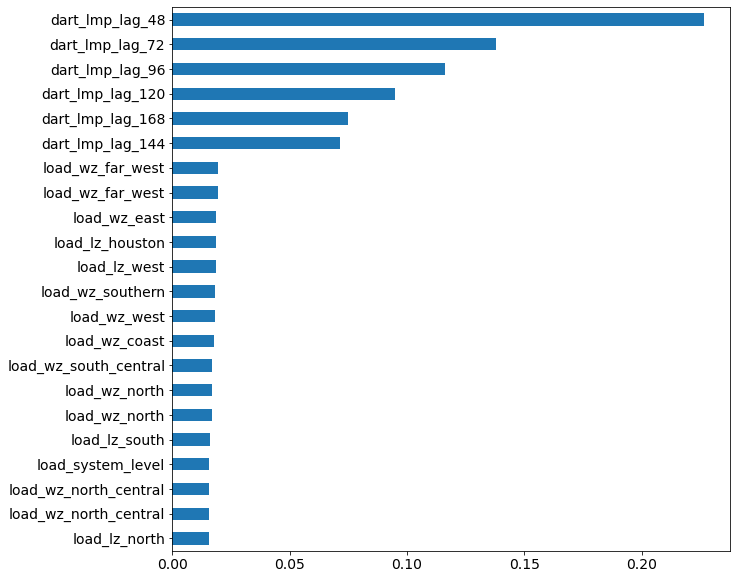

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 2}

plt.rc('font', **font)

import matplotlib.pyplot as plt
feat_importances=pd.Series(rfc.feature_importances_,index=X_train.columns)
feat_importances.nsmallest(1000).plot(kind='barh')
sns.set(font_scale = 2)
plt.show()

In [14]:
lag_df_no_act=lag_df[['nspin/load','rrs/load','regdn/load','regup/load','net_load_north','net_load_south','net_load_sys','net_load_west','wind/load_west ratio','wind/load_south ratio','wind/load_north ratio','wind/load_sys ratio','ercot_renewable_gen_out_forecast','ercot_all_gen_out_forecast','ercot_new_gen_out_forecast','volume','low','high','gas_price_average','deals','coast','east','north_central','southern','north','south_central','west','ercot_asp_regdn','ercot_asp_rrs','ercot_asp_regup','ercot_asp_nspin','ercot_asp_regdn','far_west','wind_lz_west','wind_lz_north','load_wz_southern','wind_system_level','solar_system_level','wind_lz_south_houston','load_lz_houston','load_wz_west','load_wz_north_central','load_wz_north_central','load_lz_south','load_lz_north','load_wz_far_west','load_wz_north','load_wz_far_west','load_wz_north','load_wz_east','load_wz_south_central','load_system_level','load_wz_coast','load_lz_west','dart_mcc_lag_168','dart_mcc_lag_144','dart_mcc_lag_120','dart_mcc_lag_96','dart_mcc_lag_72','dart_mcc_lag_48','spike']]

In [14]:

lag_df_lmp_no_act=lag_df_lmp[['nspin/load','rrs/load','regdn/load','regup/load','net_load_north','net_load_south','net_load_sys','net_load_west','wind/load_west ratio','wind/load_south ratio','wind/load_north ratio','wind/load_sys ratio','ercot_renewable_gen_out_forecast','ercot_all_gen_out_forecast','ercot_new_gen_out_forecast','volume','low','high','gas_price_average','deals','coast','east','north_central','southern','north','south_central','west','ercot_asp_regdn','ercot_asp_rrs','ercot_asp_regup','ercot_asp_nspin','ercot_asp_regdn','far_west','wind_lz_west','wind_lz_north','load_wz_southern','wind_system_level','solar_system_level','wind_lz_south_houston','load_lz_houston','load_wz_west','load_wz_north_central','load_wz_north_central','load_lz_south','load_lz_north','load_wz_far_west','load_wz_north','load_wz_far_west','load_wz_north','load_wz_east','load_wz_south_central','load_system_level','load_wz_coast','load_lz_west','dart_lmp_lag_168','dart_lmp_lag_144','dart_lmp_lag_120','dart_lmp_lag_96','dart_lmp_lag_72','dart_lmp_lag_48','spike']]

In [17]:
lag_df_lmp_act.head()

,node_name,dart_lmp,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,wind_lz_west,wind_lz_north,wind_lz_south_houston,wind_system_level,solar_system_level,coast,east,north_central,far_west,southern,north,south_central,west,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,ercot_asp_rrs,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,gas_price_average,deals,high,low,volume,price_lag_168,price_lag_144,price_lag_120,price_lag_96,price_lag_72,price_lag_48,price_lag_26,price_lag_25,price_lag_24,ep_hour,ep_day,ep_month,ep_quarter,ep_year,ep_day_of_month,ep_day_of_week,ep_day_of_year,ep_week_of_year,ep_weekday_name,ep_month_name,ep_season_name,ep_day_type,row_type,prediction,price_forecast_id,wind/load_sys ratio,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,net_load_sys,net_load_west,net_load_south,net_load_north,regup/load,regdn/load,rrs/load,nspin/load,ACTUAL_SYSTEM_WIDE,ACTUAL_LZ_SOUTH_HOUSTON,ACTUAL_LZ_WEST,ACTUAL_LZ_NORTH,wind_sys_error,wind_sys_error%,wind_west_error,wind_west_error%,wind_south_error,wind_south_error%,wind_north_error,wind_north_error%,NORTH,SOUTH,WEST,HOUSTON,TOTAL,load_sys_error,load_sys_error%,load_west_error,load_west_error%,load_south_error,load_south_error%,load_north_error,load_north_error%,load_houston_error,load_houston_error%,dart_lmp_lag_168,dart_lmp_lag_144,dart_lmp_lag_120,dart_lmp_lag_96,dart_lmp_lag_72,dart_lmp_lag_48,spike
0,AMISTAD_ALL,0.325,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.033,1422.41,6620.4399,40213.353,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.0,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353,-6156.705138,7099.340464,13161.649538,0.00664,0.010842,0.074204,0.028796,4687.64,2298.12,2276.26,113.26,-10196.36,-2.175159,-8371.64,-3.677805,-1330.88,-0.579117,-493.84,-4.360233,12838.31,10250.57,4298.71,10540.33,37927.91,-2285.443,-0.060258,-192.484862,-0.044777,-477.770464,-0.046609,-930.439538,-0.072474,-684.738225,-0.064964,0.0,0.0,0.0,0.0,0.0,0.0,0
1,AMOCO_PUN1,1.295,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.033,1422.41,6620.4399,40213.353,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.0,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353,-6156.705138,7099.340464,13161.649538,0.00664,0.010842,0.074204,0.028796,4687.64,2298.12,2276.26,113.26,-10196.36,-2.175159,-8371.64,-3.677805,-1330.88,-0.579117,-493.84,-4.360233,12838.31,10250.57,4298.71,10540.33,37927.91,-2285.443,-0.060258,-192.484862,-0.044777,-477.770464,-0.046609,-930.439538,-0.072474,-684.738225,-0.064964,0.0,0.0,0.0,0.0,0.0,0.0,0
2,AMOCO_PUN2,1.295,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.033,1422.41,6620.4399,40213.353,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.0,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353,-6156.705138,7099.340464,13161.649538,0.00664,0.010842,0.074204,0.028796,4687.64,2298.12,2276.26,113.26,-10196.36,

In [14]:

lag_df_lmp_act=lag_df_lmp_act[['ACTUAL_SYSTEM_WIDE','ACTUAL_LZ_SOUTH_HOUSTON','wind_sys_error','wind_west_error%','wind_west_error','wind_west_error%','wind_south_error','wind_south_error%','wind_north_error','NORTH','SOUTH','WEST','HOUSTON','TOTAL','load_sys_error','load_sys_error%','load_west_error','load_west_error%','load_south_error','load_south_error%','load_north_error','load_north_error%','load_houston_error','load_houston_error%','ACTUAL_LZ_WEST','ACTUAL_LZ_NORTH','nspin/load','rrs/load','regdn/load','regup/load','net_load_north','net_load_south','net_load_sys','net_load_west','wind/load_west ratio','wind/load_south ratio','wind/load_north ratio','wind/load_sys ratio','ercot_renewable_gen_out_forecast','ercot_all_gen_out_forecast','ercot_new_gen_out_forecast','volume','low','high','gas_price_average','deals','coast','east','north_central','southern','north','south_central','west','ercot_asp_regdn','ercot_asp_rrs','ercot_asp_regup','ercot_asp_nspin','ercot_asp_regdn','far_west','wind_lz_west','wind_lz_north','load_wz_southern','wind_system_level','solar_system_level','wind_lz_south_houston','load_lz_houston','load_wz_west','load_wz_north_central','load_wz_north_central','load_lz_south','load_lz_north','load_wz_far_west','load_wz_north','load_wz_far_west','load_wz_north','load_wz_east','load_wz_south_central','load_system_level','load_wz_coast','load_lz_west','dart_lmp_lag_168','dart_lmp_lag_144','dart_lmp_lag_120','dart_lmp_lag_96','dart_lmp_lag_72','dart_lmp_lag_48','spike']]

In [17]:
lag_df_lmp_act.describe()

,ACTUAL_SYSTEM_WIDE,ACTUAL_LZ_SOUTH_HOUSTON,wind_sys_error,wind_west_error%,wind_west_error,wind_west_error%,wind_south_error,wind_south_error%,wind_north_error,wind_north_error%,NORTH,SOUTH,WEST,HOUSTON,TOTAL,load_sys_error,load_sys_error%,load_west_error,load_west_error%,load_south_error,load_south_error%,load_north_error,load_north_error%,load_houston_error,load_houston_error%,ACTUAL_LZ_WEST,ACTUAL_LZ_NORTH,nspin/load,rrs/load,regdn/load,regup/load,net_load_north,net_load_south,net_load_sys,net_load_west,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,wind/load_sys ratio,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,volume,low,high,gas_price_average,deals,coast,east,north_central,southern,north,south_central,west,ercot_asp_regdn,ercot_asp_rrs,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,far_west,wind_lz_west,wind_lz_north,load_wz_southern,wind_system_level,solar_system_level,wind_lz_south_houston,load_lz_houston,load_wz_west,load_wz_north_central,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,dart_lmp_lag_168,dart_lmp_lag_144,dart_lmp_lag_120,dart_lmp_lag_96,dart_lmp_lag_72,dart_lmp_lag_48,spike
count,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06,3.489826e+06
mean,9.830329e+03,2.278098e+03,-4.050180e+02,-8.434625e-01,-2.980488e+02,-8.434625e-01,-9.553778e+01,-1.013593e+00,-1.143141e+01,-inf,1.540546e+04,1.142082e+04,5.041547e+03,1.183189e+04,4.369972e+04,-2.696048e+00,-3.158504e-02,2.867806e+00,-6.570019e-03,-3.426567e+00,-4.200985e-02,6.963595e-01,-4.178113e-02,-3.110801e+00,-2.933983e-02,7.080516e+03,4.717156e+02,3.599659e-02,6.598171e-02,6.985256e-03,7.733518e-03,1.492162e+04,9.050609e+03,3.254037e+04,-2.339886e+03,1.477113e+00,2.155962e-01,3.410440e-02,2.464158e-01,2.946025e+03,1.475613e+04,2.752413e+03,7.374300e+04,2.985283e+00,3.242744e+00,3.115080e+00,1.246897e+01,7.214858e+01,6.743051e+01,6.696401e+01,7.510027e+01,6.393507e+01,7.034620e+01,6.707049e+01,3.006221e+02,2.733903e+03,3.181533e+02,1.488459e+03,3.006221e+02,6.684432e+01,7.378565e+03,4.831470e+02,3.545624e+03,1.023535e+04,9.266931e+02,2.373635e+03,1.183500e+04,1.385927e+03,1.330211e+04,1.330211e+04,1.142424e+04,1.540477e+04,3.629481e+03,9.563508e+02,3.629481e+03,9.563508e+02,1.631281e+03,6.986972e+03,4.370241e+04,1.226420e+04,5.038679e+03,2.801797e+01,2.801799e+01,2.801800e+01,2.801801e+01,2.801801e+01,2.801803e+01,8.597621e-02
std,4.979885e+03,1.389277e+03,5.789627e+03,3.543423e+00,5.027033e+03,3.543423e+00,1.546604e+03,3.120050e+01,3.767136e+02,NaN,4.015865e+03,2.832842e+03,5.094955e+02,2.534377e+03,9.474012e+03,1.169719e+04,2.569949e-01,6.168350e+02,1.204857e-01,3.506448e+03,2.963578e-01,4.784775e+03,2.983754e-01,3.046851e+03,2.474206e-01,4.076331e+03,3.147577e+02,1.126750e-02,1.688802e-02

In [15]:
#assigning dependent and independent variables

X = lag_df_lmp_act.drop('spike', axis=1)
y = lag_df_lmp_act['spike']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=66)

In [17]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)


In [18]:
#print the results
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')

=== Confusion Matrix ===
[[952050   4442]
 [ 23440  67016]]




findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


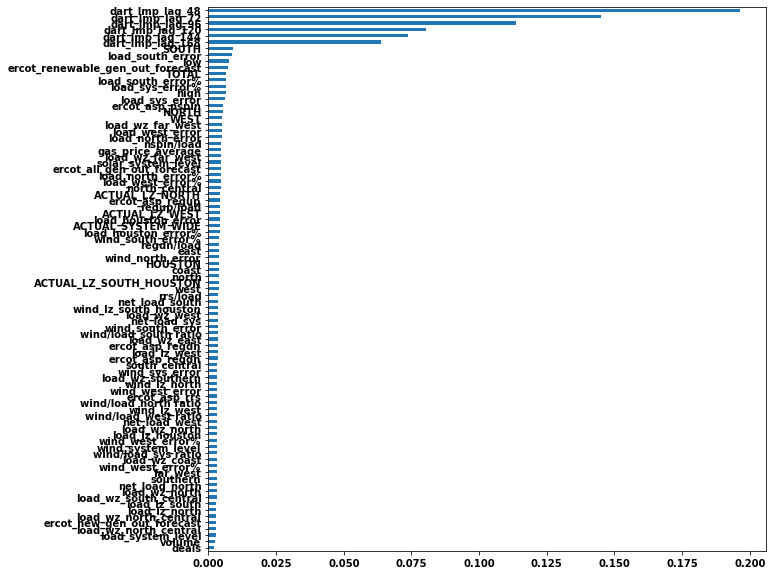

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 5}

plt.rc('font', **font)

import matplotlib.pyplot as plt
feat_importances=pd.Series(rfc.feature_importances_,index=X_train.columns)
feat_importances.nsmallest(1000).plot(kind='barh')
plt.show()

In [32]:
# plot the captured spikes using all features
y_df = pd.DataFrame()
y_df['actual']=y_test
y_df['predicted']=rfc_predict

In [33]:
df1=merged_lmp[['date_utc','dart_lmp','node_name']]

In [34]:
y_df['check']=np.where((y_df['actual']==y_df['predicted']) & (y_df['actual']==1), 1,0)

In [54]:
y_df_true = y_df[y_df["check"] == 1]

In [35]:
y_df_true_nodal = y_df[y_df["actual"] == 1]

In [56]:
df_new=df1.join(y_df_true)

In [36]:
df_new_nodal=df1.join(y_df_true_nodal)

In [1]:
df_new_nodal.head()

NameError: name 'df_new_nodal' is not defined

In [37]:
df_sum=df_new_nodal.groupby(['node_name']).sum()

In [38]:
df_sum['recall']=100*(df_sum['predicted']/df_sum['actual'])

In [39]:
df_sum.describe()

,dart_lmp,actual,predicted,check,recall
count,1.930000e+02,193.000000,193.000000,193.000000,193.000000
mean,5.066223e+05,468.683938,347.233161,347.233161,79.387226
std,1.725600e+05,180.337844,17.128574,17.128574,15.925015
min,4.405500e+05,348.000000,302.000000,302.000000,16.907437
25%,4.703572e+05,384.000000,336.000000,336.000000,73.784355
50%,4.786732e+05,418.000000,347.000000,347.000000,86.274510
75%,4.946609e+05,470.000000,359.000000,359.000000,89.971347
max,2.713178e+06,1869.000000,395.000000,395.000000,98.567335


In [28]:
df_merged = df_new[df_new["check"] == 1]

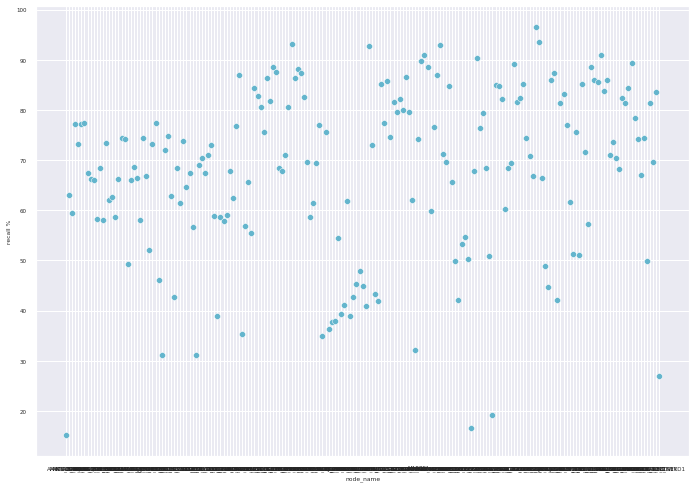

In [39]:
sns.scatterplot(data=df_sum, x="node_name",y="recall",color="c", ci=None)
plt.gcf().set_size_inches(11.7, 8.27)
plt.ylabel('recall %')
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
#sns.set(font_scale = 0.5)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


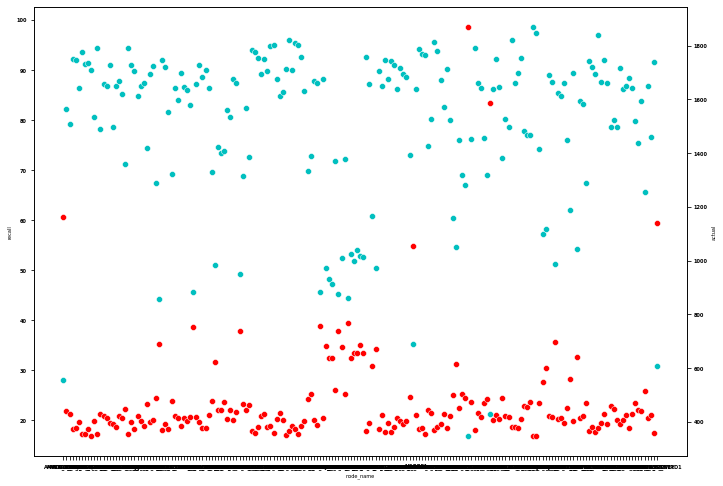

In [40]:
sns.scatterplot(data=df_sum, x="node_name",y="recall",color="c", ci=None)
ax2 = plt.twinx()
sns.scatterplot(data=df_sum, x="node_name",y="actual",ax=ax2,color="r", ci=None)
plt.gcf().set_size_inches(11.7, 8.27)
plt.xticks(rotation = 90)
plt.xlabel('node_name', fontsize=2)
plt.xticks(fontsize=0.1)

In [44]:
df_sum.describe()

,dart_mcc,actual,predcited,recall
count,1.930000e+02,193.000000,193.000000,193.000000
mean,5.324268e+05,457.948187,283.176166,67.770719
std,1.678386e+05,197.271697,25.590934,16.856400
min,4.737307e+05,309.000000,183.000000,15.099010
25%,4.919136e+05,356.000000,268.000000,58.562368
50%,4.999709e+05,390.000000,286.000000,69.689119
75%,5.211824e+05,482.000000,300.000000,81.435644
max,2.665982e+06,1893.000000,350.000000,96.562500


In [36]:
merged_mcc.head(5)

,node_name,dart_mcc,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,wind_lz_west,wind_lz_north,wind_lz_south_houston,wind_system_level,solar_system_level,coast,east,north_central,far_west,southern,north,south_central,west,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,ercot_asp_rrs,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,gas_price_average,deals,high,low,volume,price_lag_168,price_lag_144,price_lag_120,price_lag_96,price_lag_72,price_lag_48,price_lag_26,price_lag_25,price_lag_24,ep_hour,ep_day,ep_month,ep_quarter,ep_year,ep_day_of_month,ep_day_of_week,ep_day_of_year,ep_week_of_year,ep_weekday_name,ep_month_name,ep_season_name,ep_day_type,row_type,prediction,price_forecast_id,wind/load_sys ratio,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,net_load_sys,net_load_west,net_load_south,net_load_north,regup/load,regdn/load,rrs/load,nspin/load
0,AMISTAD_ALL,0.530466,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.033,1422.41,6620.4399,40213.353,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.0,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353,-6156.705138,7099.340464,13161.649538,0.00664,0.010842,0.074204,0.028796
1,AMOCO_PUN1,2.150466,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.033,1422.41,6620.4399,40213.353,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.0,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353,-6156.705138,7099.340464,13161.649538,0.00664,0.010842,0.074204,0.028796
2,AMOCO_PUN2,2.150466,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.033,1422.41,6620.4399,40213.353,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.0,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353,-6156.705138,7099.340464,13161.649538,0.00664,0.010842,0.074204,0.028796
3,ATK_ATKINSG7,0.190466,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.033,1422.41,6620.4399,40213.353,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.0,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.353,-6156.705138,7099.340464,13161.649538,0.00664,0.010842,0.074204,0.028796
4,AUSTPL_ALL,0.930466,2019-04-06 06:00:00,15.51,3236.8301,11225.068225,1389.0699,11909.0996,10728.340464,13768.749538,3134.0701,869.033,1422.41,6620.4399,40213.353,11632.4004,4491.194862,10647.9,607.1,3629.0,14884.0,0.0,71.2,64.0,69.0,73.5,75.2,65.0,72.5,74.0,267.0,1158.0,436.0,2984.0,1971.0,27080.0,1152.0,2.64,14.0,2.67,2.62,89000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6,4,2,2019,6,5,96,14,Saturday,April,Spring,Weekend,train,12.453502,e83f2f9b-0e70-4641-b0cd-469d9c9a1a20,0.370126,2.370839,0.338263,0.044093,25329.

In [37]:
merged_mcc.tail(5)

,node_name,dart_mcc,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,wind_lz_west,wind_lz_north,wind_lz_south_houston,wind_system_level,solar_system_level,coast,east,north_central,far_west,southern,north,south_central,west,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,ercot_asp_rrs,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,gas_price_average,deals,high,low,volume,price_lag_168,price_lag_144,price_lag_120,price_lag_96,price_lag_72,price_lag_48,price_lag_26,price_lag_25,price_lag_24,ep_hour,ep_day,ep_month,ep_quarter,ep_year,ep_day_of_month,ep_day_of_week,ep_day_of_year,ep_week_of_year,ep_weekday_name,ep_month_name,ep_season_name,ep_day_type,row_type,prediction,price_forecast_id,wind/load_sys ratio,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,net_load_sys,net_load_west,net_load_south,net_load_north,regup/load,regdn/load,rrs/load,nspin/load
1674299,CALLAHA_WND1,0.520566,2020-04-04 14:00:00,20.41,2642.05,8486.89059,1098.61,10453.2002,7740.21006,11939.343082,3573.53,818.596,1080.78,4419.4199,32881.776062,8795.5898,4715.332329,5869.2,256.4,2559.3,8684.9,91.3,61.6,49.0,40.5,45.5,72.0,41.0,49.0,43.4,320.0,1810.0,179.0,2998.0,3253.0,27260.0,3243.0,1.505,6.0,1.51,1.5,30000.0,0.63,19.22,16.28,24.28,3.41,8.47,1.27,7.68,2.92,14,4,4,2,2020,4,5,95,14,Saturday,April,Spring,Weekend,train,16.224713,8cfe0614-d51e-4bf9-b8c1-a6c2fc001cbf,0.264125,1.244705,0.33065,0.021475,24105.576062,-1153.867671,5180.91006,11682.943082,0.009732,0.005444,0.091175,0.055046
1674300,CAL_PUN1,0.234434,2020-04-04 14:00:00,20.41,2642.05,8486.89059,1098.61,10453.2002,7740.21006,11939.343082,3573.53,818.596,1080.78,4419.4199,32881.776062,8795.5898,4715.332329,5869.2,256.4,2559.3,8684.9,91.3,61.6,49.0,40.5,45.5,72.0,41.0,49.0,43.4,320.0,1810.0,179.0,2998.0,3253.0,27260.0,3243.0,1.505,6.0,1.51,1.5,30000.0,0.63,19.22,16.28,24.28,3.41,8.47,1.27,7.68,2.92,14,4,4,2,2020,4,5,95,14,Saturday,April,Spring,Weekend,train,16.224713,8cfe0614-d51e-4bf9-b8c1-a6c2fc001cbf,0.264125,1.244705,0.33065,0.021475,24105.576062,-1153.867671,5180.91006,11682.943082,0.009732,0.005444,0.091175,0.055046
1674301,CAPRIDG4_CR4,0.618066,2020-04-04 14:00:00,20.41,2642.05,8486.89059,1098.61,10453.2002,7740.21006,11939.343082,3573.53,818.596,1080.78,4419.4199,32881.776062,8795.5898,4715.332329,5869.2,256.4,2559.3,8684.9,91.3,61.6,49.0,40.5,45.5,72.0,41.0,49.0,43.4,320.0,1810.0,179.0,2998.0,3253.0,27260.0,3243.0,1.505,6.0,1.51,1.5,30000.0,0.63,19.22,16.28,24.28,3.41,8.47,1.27,7.68,2.92,14,4,4,2,2020,4,5,95,14,Saturday,April,Spring,Weekend,train,16.224713,8cfe0614-d51e-4bf9-b8c1-a6c2fc001cbf,0.264125,1.244705,0.33065,0.021475,24105.576062,-1153.867671,5180.91006,11682.943082,0.009732,0.005444,0.091175,0.055046
1674302,CARBN_BSP_1,4.070566,2020-04-04 14:00:00,20.41,2642.05,8486.89059,1098.61,10453.2002,7740.21006,11939.343082,3573.53,818.596,1080.78,4419.4199,32881.776062,8795.5898,4715.332329,5869.2,256.4,2559.3,8684.9,91.3,61.6,49.0,40.5,45.5,72.0,41.0,49.0,43.4,320.0,1810.0,179.0,2998.0,3253.0,27260.0,3243.0,1.505,6.0,1.51,1.5,30000.0,0.63,19.22,16.28,24.28,3.41,8.47,1.27,7.68,2.92,14,4,4,2,2020,4,5,95,14,Saturday,April,Spring,Weekend,train,16.224713,8cfe0614-d51e-4bf9-b8c1-a6c2fc001cbf,0.264125,1.244705,0.33065,0.021475,24105.576062,-1153.867671,5180.91006,11682.943082,0.009732,0.005444,0.091175,0.055046
1674303,CBY_CBY_G1,NaN,2020-04-04 14:00:00,20.41,2642.05,8486.89059,1098.61,10453.2002,7740.21006,11939.343082,3573.53,818.596,1080.78,4419.4199,32881.776062,8795.5898,4715.332329,5869.2,256.4,2559.3,8684.9,91.3,61.6,49.0,40.5,45.5,72.0,41.0,49.0,43.4,320.0,1810.0,179.0,2998.0,3253.0,27260.0,3243.0,1.505,6.0,1.51,1.5,30000.0,0.63,19.22,16.28,24.28,3.41,8.47,1.27,7.68,2.92,14,4,4,2,2020,4,5,95,14,Saturday,April,Spring,Weekend,train,16.224713,8cfe0614-d51e-4bf9-b8c1-a6c2fc0

In [38]:
train_data.tail()

,date_utc,price,load_wz_southern,load_lz_houston,load_wz_west,load_wz_north_central,load_lz_south,load_lz_north,load_wz_far_west,load_wz_north,load_wz_east,load_wz_south_central,load_system_level,load_wz_coast,load_lz_west,wind_lz_west,wind_lz_north,wind_lz_south_houston,wind_system_level,solar_system_level,coast,east,north_central,far_west,southern,north,south_central,west,ercot_asp_regup,ercot_asp_nspin,ercot_asp_regdn,ercot_asp_rrs,ercot_renewable_gen_out_forecast,ercot_all_gen_out_forecast,ercot_new_gen_out_forecast,gas_price_average,deals,high,low,volume,price_lag_168,price_lag_144,price_lag_120,price_lag_96,price_lag_72,price_lag_48,price_lag_26,price_lag_25,price_lag_24,ep_hour,ep_day,ep_month,ep_quarter,ep_year,ep_day_of_month,ep_day_of_week,ep_day_of_year,ep_week_of_year,ep_weekday_name,ep_month_name,ep_season_name,ep_day_type,row_type,prediction,price_forecast_id,wind/load_sys ratio,wind/load_west ratio,wind/load_south ratio,wind/load_north ratio,net_load_sys,net_load_west,net_load_south,net_load_north,regup/load,regdn/load,rrs/load,nspin/load
18003,2021-05-27 19:00:00,22.83,4950.1377,16744.732238,1597.7709,17672.4492,15238.365553,20414.953092,4233.3325,1107.7561,2221.1824,9150.0664,58285.958862,17353.2637,5887.907980,5844.6,990.8,5474.8,12310.2,5455.0,84.8,85.5,81.50,88.5,88.6,82.5,82.5,84.4,559.0,1686.0,412.0,2658.0,4983.0,10679.0,3649.0,2.9,2.0,2.9,2.9,10000.0,27.87,1.99,27.46,9.77,31.89,30.32,23.92,27.68,33.53,19,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,18.869834,9f6e34da-c97e-4094-bbb7-b175c038d990,0.211204,0.992645,0.359277,0.048533,40520.758862,43.307980,9763.565553,19424.153092,0.009591,0.007069,0.045603,0.028926
18004,2021-05-27 20:00:00,31.74,5125.4849,17232.522581,1651.5786,17879.1836,16134.348257,20688.986671,4330.2407,1124.3276,2276.6875,9837.1436,60082.904297,17858.2578,6027.046787,4092.0,913.3,5834.4,10839.7,5082.7,84.4,87.5,85.50,91.0,89.8,85.5,86.5,87.6,497.0,1538.0,411.0,2605.0,4839.0,10679.0,3649.0,2.9,2.0,2.9,2.9,10000.0,26.45,-0.74,26.64,9.85,29.74,33.47,27.68,33.53,33.89,20,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,21.168086,08546865-2fcd-49e7-8a2d-cf869b295a66,0.180412,0.678939,0.361614,0.044144,44160.504297,1935.046787,10299.948257,19775.686671,0.008272,0.006841,0.043357,0.025598
18005,2021-05-27 21:00:00,33.16,5226.5005,17768.113272,1713.6847,18105.7090,16254.358280,20990.634926,4361.3687,1126.6569,2350.5168,9814.5547,61112.696400,18413.7051,6099.589811,3466.4,918.7,6023.6,10408.7,4518.0,86.4,87.0,86.50,94.5,89.8,85.0,87.0,88.4,493.0,1538.0,423.0,2605.0,4649.0,10677.0,3649.0,2.9,2.0,2.9,2.9,10000.0,30.46,-3.35,21.57,9.77,27.27,39.52,33.53,33.89,29.90,21,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,22.500452,766c22ea-c0d7-4bdb-bbbc-bfc54cd0802d,0.170320,0.568301,0.370584,0.043767,46185.996400,2633.189811,10230.758280,20071.934926,0.008067,0.006922,0.042626,0.025167
18006,2021-05-27 22:00:00,37.13,5265.0986,17652.102094,1758.8250,18935.8008,16583.134033,21906.861518,4378.8110,1200.0313,2401.8364,10094.3545,62327.808400,18293.0508,6185.710705,3671.5,901.2,6194.3,10767.0,3535.8,85.1,87.5,86.75,94.5,90.2,86.0,83.5,90.8,463.0,1538.0,476.0,2605.0,4084.0,10332.0,3649.0,2.9,2.0,2.9,2.9,10000.0,31.26,-4.53,20.90,11.99,26.03,38.30,33.89,29.90,29.00,22,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,24.859748,e233f2d3-f2aa-466d-8af1-e056b36153cf,0.172748,0.593545,0.373530,0.041138,48025.008400,2514.210705,10388.834033,21005.661518,0.007428,0.007637,0.041795,0.024676
18007,2021-05-27 23:00:00,35.05,5200.6006,17351.615237,1819.7872,18829.4824,16591.066648,21870.466269,4251.9087,1159.4504,2490.6829,10157.0898,61890.363403,17981.3613,6077.215250,4399.2,869.5,6380.3,11649.0,2673.2,84.6,87.0,86.00,94.5,89.4,84.0,87.5,90.8,432.0,1538.0,489.0,2605.0,3844.0,10332.0,3649.0,2.9,2.0,2.9,2.9,10000.0,17.99,-6.99,17.79,4.60,20.72,27.50,29.90,29.00,18.64,23,27,5,2,2021,27,3,147,21,Thursday,May,Spring,Weekday,hold_out,23.987415,0488a56d-d64f-48a4-b8dd-c5

In [40]:
mcc_raw.tail()

,node_name,start_time,end_time,dart_mcc
2113374,CALLAHA_WND1,2020-04-04 14:00:00,2020-04-04 15:00:00,0.520566
2113375,CAL_PUN1,2020-04-04 14:00:00,2020-04-04 15:00:00,0.234434
2113376,CAPRIDG4_CR4,2020-04-04 14:00:00,2020-04-04 15:00:00,0.618066
2113377,CARBN_BSP_1,2020-04-04 14:00:00,2020-04-04 15:00:00,4.070566
2113378,CBY_CBY_G1,2020-04-04 14:00:00,2020-09,NaN


In [ ]:
for node in merged_lmp ['node_name']: print (merged_lmp[merged_lmp["node_name"] == AMISTAD_ALL])

In [63]:
df_results=merged_lmp["node_name"]

In [64]:
df_results.head()


0     AMISTAD_ALL
1      AMOCO_PUN1
2      AMOCO_PUN2
3    ATK_ATKINSG7
4      AUSTPL_ALL
Name: node_name, dtype: object

In [68]:
c=0

In [42]:
d2=[]

In [43]:
for node in merged_lmp ['node_name'].head(40):
#for node in merged_lmp.loc[2:5,['node_name']]:
    merged=merged_lmp[merged_lmp["node_name"] == node]
    #take the percentile for each node
    lmp_perc=merged['dart_lmp'].quantile(0.9)
    merged['spike'] = np.where(merged['dart_lmp']>lmp_perc, 1, 0)
    lag_merged=lag_column_generator(merged, [48, 72, 96, 120,144, 168], 'dart_lmp')
    lag_merged_act=lag_merged[['ACTUAL_SYSTEM_WIDE','ACTUAL_LZ_SOUTH_HOUSTON','wind_sys_error','wind_west_error%','wind_west_error','wind_west_error%','wind_south_error','wind_south_error%','wind_north_error','NORTH','SOUTH','WEST','HOUSTON','TOTAL','load_sys_error','load_sys_error%','load_west_error','load_west_error%','load_south_error','load_south_error%','load_north_error','load_north_error%','load_houston_error','load_houston_error%','ACTUAL_LZ_WEST','ACTUAL_LZ_NORTH','nspin/load','rrs/load','regdn/load','regup/load','net_load_north','net_load_south','net_load_sys','net_load_west','wind/load_west ratio','wind/load_south ratio','wind/load_north ratio','wind/load_sys ratio','ercot_renewable_gen_out_forecast','ercot_all_gen_out_forecast','ercot_new_gen_out_forecast','volume','low','high','gas_price_average','deals','coast','east','north_central','southern','north','south_central','west','ercot_asp_regdn','ercot_asp_rrs','ercot_asp_regup','ercot_asp_nspin','ercot_asp_regdn','far_west','wind_lz_west','wind_lz_north','load_wz_southern','wind_system_level','solar_system_level','wind_lz_south_houston','load_lz_houston','load_wz_west','load_wz_north_central','load_wz_north_central','load_lz_south','load_lz_north','load_wz_far_west','load_wz_north','load_wz_far_west','load_wz_north','load_wz_east','load_wz_south_central','load_system_level','load_wz_coast','load_lz_west','dart_lmp_lag_168','dart_lmp_lag_144','dart_lmp_lag_120','dart_lmp_lag_96','dart_lmp_lag_72','dart_lmp_lag_48','spike']]
    X = lag_merged_act.drop('spike', axis=1)
    y = lag_merged_act['spike']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=66)
    rfc = RandomForestClassifier()
    rfc.fit(X_train,y_train)
      
    # predictions
    rfc_predict = rfc.predict(X_test)
    cfm=confusion_matrix(y_test, rfc_predict)
    #recall[c]=cfm[1,1]/(cfm[1,0]+cfm[1,1])
    #spikes[c]=cfm[1,0]+cfm[1,1]
    #df_results["recall"]=np.where(df_results["node_name"] == node,cfmatrix[1,1]/(cfmatrix[1,0]+cfmatrix[1,1] )
    #df_results["spikes"]=np.where(df_results["node_name"] == node,cfmatrix[1,0]+cfmatrix[1,1]) 
    #c=c+1
    d2.append(
        {
            'node_name': node,
            'recall': cfm[1,1]/(cfm[1,0]+cfm[1,1]),
            'spikes': cfm[1,0]+cfm[1,1]
        }
    )

In [39]:
pd.DataFrame(d)

,node_name,recall,spikes
0,AMISTAD_ALL,0.282403,1165
1,AMOCO_PUN1,0.338600,443
2,AMOCO_PUN2,0.334086,443
3,ATK_ATKINSG7,0.365333,375
4,AUSTPL_ALL,0.367725,378
5,AMISTAD_ALL,0.296137,1165
6,AMOCO_PUN1,0.343115,443
7,AMOCO_PUN2,0.334086,443
8,ATK_ATKINSG7,0.373333,375
9,AUSTPL_ALL,0.359788,378


In [44]:
pd.DataFrame(d2)

,node_name,recall,spikes
0,AMISTAD_ALL,0.228938,546
1,AMOCO_PUN1,0.349462,558
2,AMOCO_PUN2,0.347670,558
3,ATK_ATKINSG7,0.398148,540
4,AUSTPL_ALL,0.377532,543
5,AZ_ALL,0.371377,552
6,BASTEN_CCU,0.366355,535
7,BOSQ_BSQSU_5,0.353480,546
8,BRAUNIG_VHB1,0.363636,539
9,BRAUNIG_VHB3,0.375231,541


In [40]:
 lmp_perc=merged['dart_lmp'].quantile(0.9)

In [41]:
lmp_perc

19.291999999999998

In [48]:
print (merged_lmp[merged_lmp["node_name"] == 'AMISTAD_ALL'])

           node_name  dart_lmp            date_utc  price  load_wz_southern  \
0        AMISTAD_ALL    0.3250 2019-04-06 06:00:00  15.51         3236.8301   
193      AMISTAD_ALL   68.1775 2019-04-06 07:00:00  16.57         3071.9199   
386      AMISTAD_ALL    9.0075 2019-04-06 08:00:00  15.51         2879.2000   
579      AMISTAD_ALL    4.3525 2019-04-06 09:00:00  14.91         2673.6509   
772      AMISTAD_ALL    0.6550 2019-04-06 10:00:00  17.75         2586.1238   
...              ...       ...                 ...    ...               ...   
3488861  AMISTAD_ALL    4.7525 2021-05-27 19:00:00  22.83         4950.1377   
3489054  AMISTAD_ALL    0.0600 2021-05-27 20:00:00  31.74         5125.4849   
3489247  AMISTAD_ALL    1.9925 2021-05-27 21:00:00  33.16         5226.5005   
3489440  AMISTAD_ALL    0.1525 2021-05-27 22:00:00  37.13         5265.0986   
3489633  AMISTAD_ALL    1.0700 2021-05-27 23:00:00  35.05         5200.6006   

         load_lz_houston  load_wz_west  load_wz_nor

In [49]:
confusion_matrix(y_test, rfc_predict)

array([[952050,   4442],
       [ 23440,  67016]])

In [50]:
cfmatrix=confusion_matrix(y_test, rfc_predict)

In [58]:
cfmatrix[1,1]/(cfmatrix[1,0]+cfmatrix[1,1])

0.7408684885469179

In [57]:
cfmatrix[1,0]

23440